# Import Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Text processing
import re
import string

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Train-test split
from sklearn.model_selection import train_test_split

# Model Training
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# Word cloud
from wordcloud import WordCloud

#Tokenization
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
import string
import re

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# download nltk resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Load the Dataset Files

In [3]:
fake_df = pd.read_csv("/content/Fake.csv")
real_df = pd.read_csv("/content/True.csv")

In [4]:
print("Fake News Shape:", fake_df.shape)
print("Real News Shape:", real_df.shape)

Fake News Shape: (23481, 4)
Real News Shape: (21417, 4)


In [5]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
# Add Labels to Each Dataset
fake_df['label'] = 0   # Fake news
real_df['label'] = 1   # Real news

In [8]:
# Merge Fake and Real News
df = pd.concat([fake_df, real_df], axis=0)
df = df.sample(frac=1, random_state=29).reset_index(drop=True)

# Final Dataset Overview

In [9]:
# check for initials rows
df.head()

,title,text,subject,date,label
0,Trump Threatens Electoral ‘Bloodbath’ If Repu...,House Republicans have released their version ...,News,"March 8, 2017",0
1,OBAMA RELEASES TOP IRANIAN SCIENTIST…LEAVES 4 ...,On Wednesday Barack Obama lashed out at CBS re...,Government News,"Jul 20, 2015",0
2,Southern African leaders to discuss Zimbabwe o...,JOHANNESBURG (Reuters) - The Southern African ...,worldnews,"November 19, 2017",1
3,"NAFTA envoys lay out proposals, try to block T...",MEXICO CITY (Reuters) - Trade negotiators from...,worldnews,"September 1, 2017",1
4,Brazil's Meirelles jokes about a vice presiden...,SAO PAULO (Reuters) - Brazil s Finance Ministe...,worldnews,"October 30, 2017",1


In [10]:
# check for rows and coloumns
df.shape

(44898, 5)

In [11]:
# basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [12]:
# descriptive statistics
df.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
#check for missing values
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [14]:
# check for duplicates
df.duplicated().sum()

np.int64(209)

In [15]:
# drop duplicates
df=df.drop_duplicates()

In [16]:
# check for final rows and coloumns
df.shape

(44689, 5)

In [17]:
# Class Distribution Check (class balance)
df['label'].value_counts()

,count
label,
0,23478
1,21211


# Data Pre-processing

In [18]:
# Create a Unified Text Column
df['content'] = df['title'] + " " + df['text']

In [19]:
def clean_text(text):
    text = text.lower()

    # Remove URLs and HTML
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'<.*?>', '', text)

    # Handle ellipsis explicitly
    text = re.sub(r'\.{2,}', ' ', text)

    # Handle repeated punctuation (!!!, ???, etc.)
    text = re.sub(r'([!?]){2,}', r'\1', text)

    # Remove all punctuation (explicit list + string.punctuation)
    punctuation_extended = string.punctuation + "“”‘’–—…"
    text = text.translate(str.maketrans('', '', punctuation_extended))

    # Explicit tokenisation
    tokens = word_tokenize(text)

    # Remove stopwords + lemmatise
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]

    return " ".join(tokens)

In [20]:
# Initialize stop_words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Apply Text Cleaning
df['clean_text'] = df['content'].apply(clean_text)

In [21]:
# Preview Cleaned Text
df[['content', 'clean_text']].head()

,content,clean_text
0,Trump Threatens Electoral ‘Bloodbath’ If Repu...,trump threatens electoral bloodbath republican...
1,OBAMA RELEASES TOP IRANIAN SCIENTIST…LEAVES 4 ...,obama release top iranian scientistleaves amer...
2,Southern African leaders to discuss Zimbabwe o...,southern african leader discus zimbabwe tuesda...
3,"NAFTA envoys lay out proposals, try to block T...",nafta envoy lay proposal try block trump noise...
4,Brazil's Meirelles jokes about a vice presiden...,brazil meirelles joke vice presidential candid...


# Exploratory Data Analysis

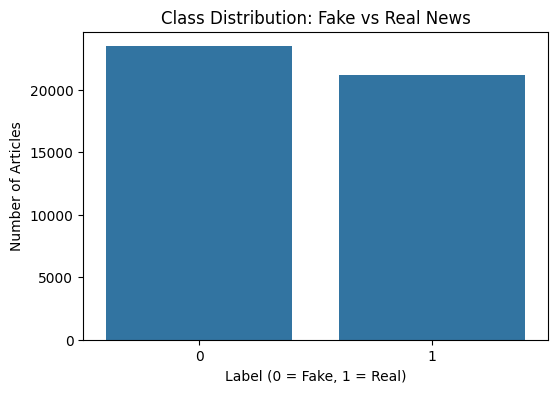

In [22]:
# Class Distribution - fake vs real
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Fake vs Real News")
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Number of Articles")
plt.show()

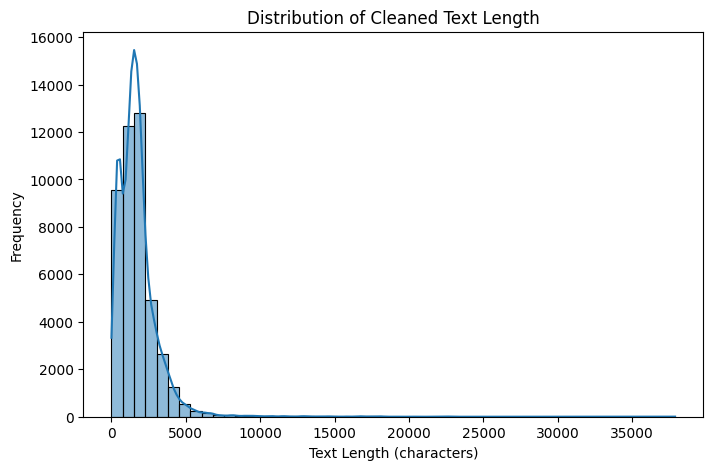

In [23]:
# Text Length Distribution (Cleaned Text)
df['text_length'] = df['clean_text'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Cleaned Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()

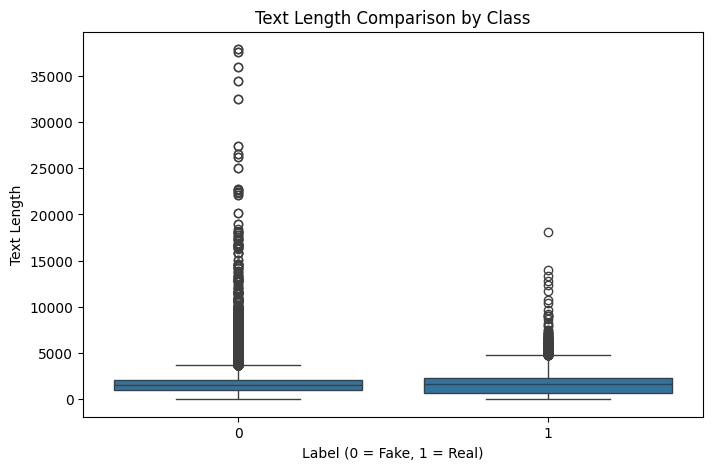

In [24]:
# Text Length by Class (Fake vs Real)
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='text_length', data=df)
plt.title("Text Length Comparison by Class")
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Text Length")
plt.show()

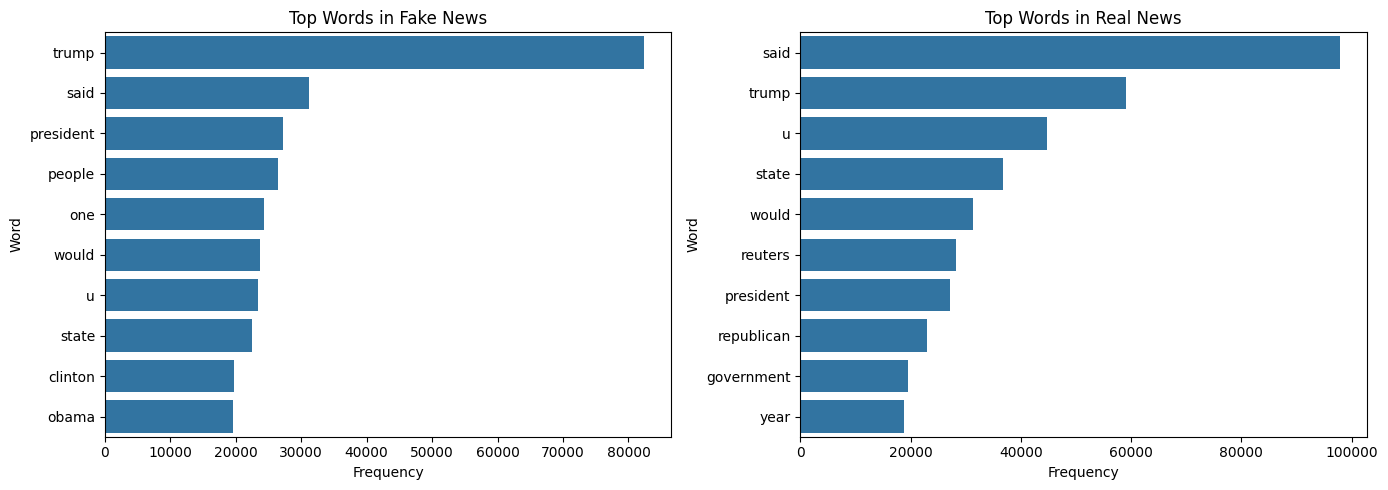

In [25]:
# Most Frequent Words (Fake vs Real)
from collections import Counter

# Separate fake and real text
fake_words = " ".join(df[df['label'] == 0]['clean_text']).split()
real_words = " ".join(df[df['label'] == 1]['clean_text']).split()

fake_common = Counter(fake_words).most_common(10)
real_common = Counter(real_words).most_common(10)

fake_df_words = pd.DataFrame(fake_common, columns=['Word', 'Frequency'])
real_df_words = pd.DataFrame(real_common, columns=['Word', 'Frequency'])

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(ax=axes[0], x='Frequency', y='Word', data=fake_df_words)
axes[0].set_title("Top Words in Fake News")

sns.barplot(ax=axes[1], x='Frequency', y='Word', data=real_df_words)
axes[1].set_title("Top Words in Real News")

plt.tight_layout()
plt.show()

# TF-IDF FEATURE EXTRACTION

In [26]:
# Define Features (X) and Target (y)
X = df['clean_text']
y = df['label']

In [27]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=29, stratify=y
)

In [28]:
# Initialise TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_df=0.7,
    min_df=2,
    ngram_range=(1, 2)
)

In [29]:
# Fit TF-IDF on Training Data
X_train_tfidf = tfidf.fit_transform(X_train)

In [30]:
# Transform Test Data Using TF-IDF
X_test_tfidf = tfidf.transform(X_test)

In [31]:
# Inspect TF-IDF Feature Matrix
print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)

TF-IDF Train Shape: (35751, 1252689)
TF-IDF Test Shape: (8938, 1252689)


In [32]:
# View Sample Feature Names
tfidf.get_feature_names_out()[:20]

array(['aa', 'aa saudi', 'aaa', 'aaa yield', 'aadhaar', 'aadhaar made',
       'aadl', 'aadl call', 'aadl facebook', 'aadl operate', 'aalo',
       'aalo united', 'aamer', 'aamer released', 'aamin',
       'aamin ambulance', 'aaminus', 'aaminus credit', 'aapl',
       'aapl amzn'], dtype=object)

# RULE-BASED MODEL IMPLEMENTATION

In [33]:
# Define a Simple Fake-News Lexicon
fake_keywords = [
    "breaking","shocking","exposed","secret","conspiracy","hoax","fake","fraud","scam","lies",
    "truth","alert","bombshell","leaked","revealed","coverup","corrupt","rigged","evil",
    "propaganda","deception","plot","agenda","deepstate","manipulated","misleading",
    "sensational","viral","clickbait","panic","fear","outrage","chaos","danger","crisis",
    "confession","hidden","anonymous","insider","threat","attack","collapse","destroy",
    "traitor","illegal","criminal","arrest","scandal","impeach","blackmail","terror",
    "forbidden","banned","censored","truthbomb","fabricated","brainwash","exaggerated",
    "distorted","falseflag","misinfo","disinfo","exposedtruth","hoaxnews","scare"
]

In [34]:
real_keywords = [
    "said","according","reported","report","reuters","statement","official","officials",
    "government","minister","president","administration","spokesperson","agency","department",
    "confirmed","announced","released","published","data","figure","statistics","survey",
    "research","study","analysis","policy","law","court","judge","decision","ruling",
    "meeting","conference","summit","session","committee","parliament","congress",
    "election","vote","campaign","result","outcome","agreement","deal","treaty",
    "budget","economy","market","finance","inflation","growth","trade","investment",
    "international","foreign","domestic","security","defence","health","education",
    "statementsaid","reportedsaid","officialsaid","reuterssaid"
]

In [35]:
# Define Rule-Based Classification Function
def rule_based_classifier(text):
    tokens = text.split()

    fake_score = sum(1 for word in tokens if word in fake_keywords)
    real_score = sum(1 for word in tokens if word in real_keywords)

    if fake_score > real_score:
        return 0   # Fake news
    else:
        return 1   # Real news

In [36]:
# Apply Rule-Based Model to Dataset
df['rule_prediction'] = df['clean_text'].apply(rule_based_classifier)

In [37]:
# Inspect Rule-Based Predictions
df[['clean_text', 'label', 'rule_prediction']].head()

,clean_text,label,rule_prediction
0,trump threatens electoral bloodbath republican...,0,1
1,obama release top iranian scientistleaves amer...,0,1
2,southern african leader discus zimbabwe tuesda...,1,1
3,nafta envoy lay proposal try block trump noise...,1,1
4,brazil meirelles joke vice presidential candid...,1,1


In [38]:
# Rule-Based Model Accuracy
rule_accuracy = accuracy_score(df['label'], df['rule_prediction'])
print("Rule-Based Model Accuracy:", rule_accuracy)

Rule-Based Model Accuracy: 0.51802456980465


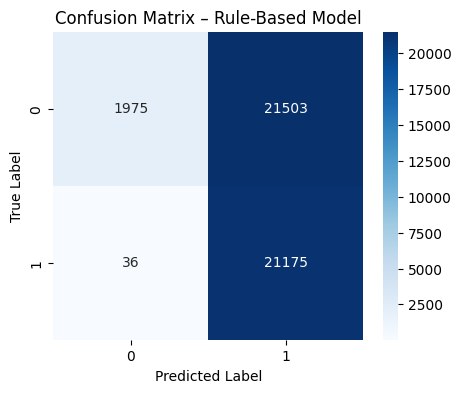

In [39]:
# Confusion Matrix for Rule-Based Model
cm_rule = confusion_matrix(df['label'], df['rule_prediction'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_rule, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Rule-Based Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [40]:
# Rule-Based Classification Report
print(classification_report(df['label'], df['rule_prediction']))

              precision    recall  f1-score   support

           0       0.98      0.08      0.15     23478
           1       0.50      1.00      0.66     21211

    accuracy                           0.52     44689
   macro avg       0.74      0.54      0.41     44689
weighted avg       0.75      0.52      0.40     44689



# Machine Learning Model Implementation

# Model 1: Naive Bayes

In [41]:
# Trains Naive Bayes on TF-IDF features
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Prediction
nb_pred = nb_model.predict(X_test_tfidf)

In [42]:
# Accuracy - Naive Bayes
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.9562541955694787


In [43]:
# @title
# Evaluation Metrics
print("Naive Bayes – Classification Report")
print(classification_report(y_test, nb_pred))

Naive Bayes – Classification Report
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      4696
           1       0.95      0.96      0.95      4242

    accuracy                           0.96      8938
   macro avg       0.96      0.96      0.96      8938
weighted avg       0.96      0.96      0.96      8938



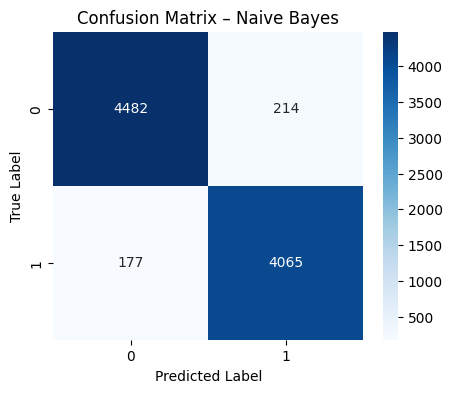

In [44]:
# Confusion Matrix – Naive Bayes
cm_nb = confusion_matrix(y_test, nb_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Naive Bayes ROC–AUC: 0.9904257598429592


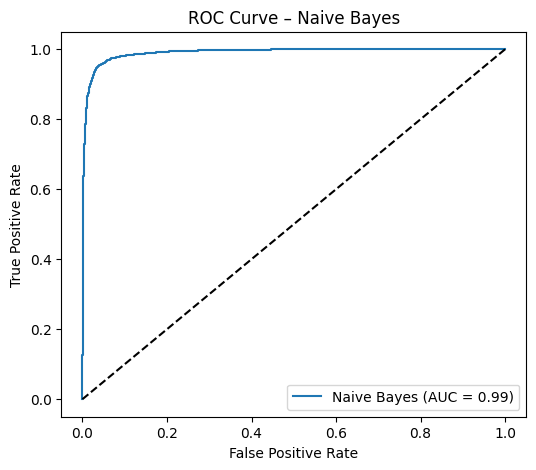

In [45]:
# ROC–AUC – Naive Bayes
nb_probs = nb_model.predict_proba(X_test_tfidf)[:, 1]
nb_auc = roc_auc_score(y_test, nb_probs)

print("Naive Bayes ROC–AUC:", nb_auc)

# ROC Curve curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {nb_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Naive Bayes")
plt.legend()
plt.show()

# Model 2: Neural Network

In [46]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(
    loss="log_loss",        # logistic regression (NN-like)
    max_iter=1000,
    tol=1e-3,
    random_state=29,
    n_jobs=-1               # use all CPU cores
)

sgd_model.fit(X_train_tfidf, y_train)

sgd_pred = sgd_model.predict(X_test_tfidf)


In [47]:
# Accuracy - Neural Network
nn_accuracy = accuracy_score(y_test, sgd_pred)
print("Neural Network Accuracy:", nn_accuracy)

Neural Network Accuracy: 0.9741552920116358


In [48]:
# Evaluation Metrics - Neural Network
print("Neural Network – Classification Report")
print(classification_report(y_test, sgd_pred))

Neural Network – Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4696
           1       0.97      0.97      0.97      4242

    accuracy                           0.97      8938
   macro avg       0.97      0.97      0.97      8938
weighted avg       0.97      0.97      0.97      8938



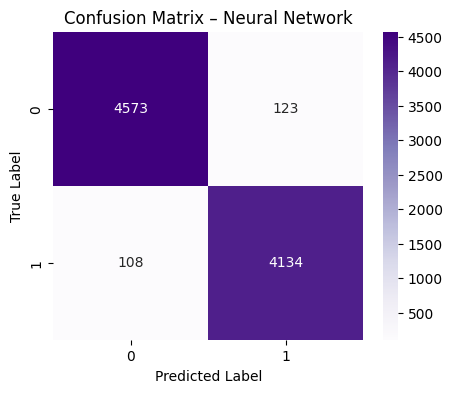

In [49]:
# Confusion Matrix - Neural Network
cm_nn = confusion_matrix(y_test, sgd_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix – Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Neural Network ROC–AUC: 0.9964863713798976


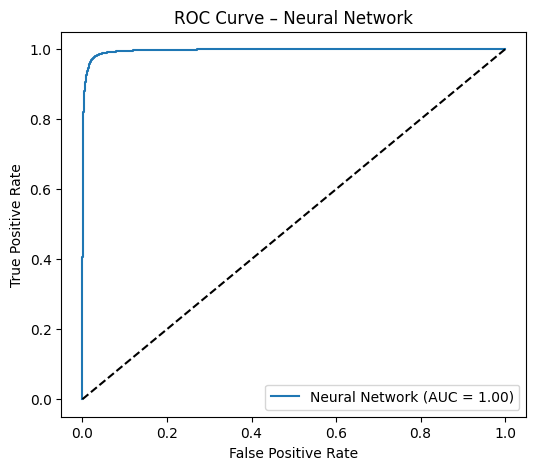

In [50]:
# ROC-AUC Score - Neural Network
nn_probs = sgd_model.predict_proba(X_test_tfidf)[:, 1]
nn_auc = roc_auc_score(y_test, nn_probs)

print("Neural Network ROC–AUC:", nn_auc)


# ROC–AUC curve – Neural Network
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {nn_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Neural Network")
plt.legend()
plt.show()

In [51]:
# Accuracy scores
nb_accuracy = accuracy_score(y_test, nb_pred)
nn_accuracy = accuracy_score(y_test, sgd_pred)

# Create comparison table
accuracy_comparison = pd.DataFrame({
    "Model": ["Rule-Based", "Naive Bayes", "Neural Network"],
    "Accuracy": [rule_accuracy, nb_accuracy, nn_accuracy]
})

accuracy_comparison

,Model,Accuracy
0,Rule-Based,0.518025
1,Naive Bayes,0.956254
2,Neural Network,0.974155


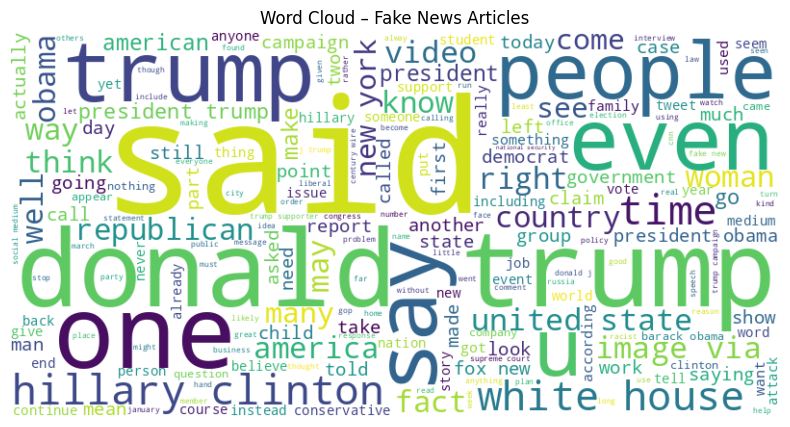

In [52]:
# Word Cloud – Fake News
fake_text = " ".join(df[df['label'] == 0]['clean_text'])

wordcloud_fake = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Fake News Articles")
plt.show()

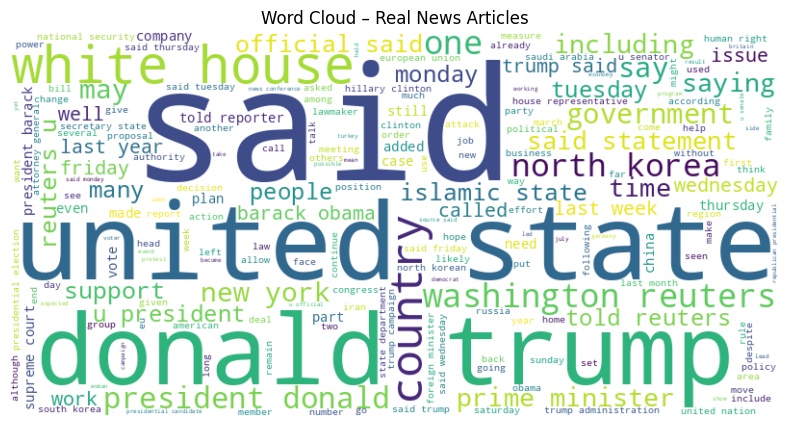

In [53]:
# Word Cloud – Real News
real_text = " ".join(df[df['label'] == 1]['clean_text'])

wordcloud_real = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(real_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Real News Articles")
plt.show()

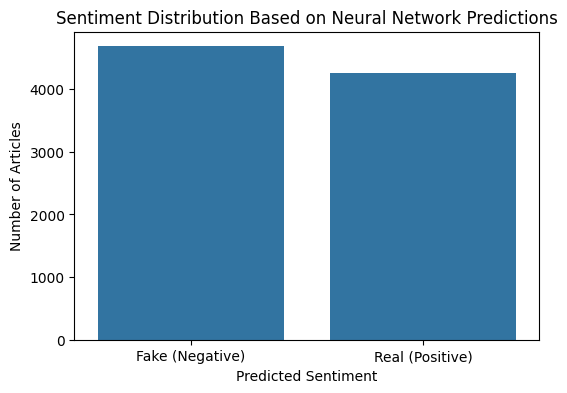

In [54]:
# Sentiment Distribution Plot

sentiment_map = {0: "Fake (Negative)", 1: "Real (Positive)"}
sentiment_series = pd.Series(sgd_pred).map(sentiment_map)

# Count distribution
sentiment_counts = sentiment_series.value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values
)

plt.title("Sentiment Distribution Based on Neural Network Predictions")
plt.xlabel("Predicted Sentiment")
plt.ylabel("Number of Articles")
plt.show()